In [9]:
import cython
%load_ext cython

import numpy as np
from sympy import Matrix
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
from IPython.display import clear_output
from matplotlib.animation import FuncAnimation, ArtistAnimation

plt.style.use('seaborn-pastel')

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [2]:
%%cython
from libc.math cimport sin, cos, sqrt

def all_connections(cluster, radius_shell, delta_shell):
    """
    this function returns a list of lists with all the possible connection between points.
    arg:
        cluster: np.array() 2xN_points.
        radius_shell: double. Radius of the facilitation shell.
        delta_shell: double. width of the facilitation shell. 
    
    returns:
        possible_connections: list of lists. the first index run on the points. the second index on all the connection with that point.
    """
    cdef int N = 0
    cdef double x_i, x_j, y_i, y_j, distance
    cdef list possible_connections = []
    for i in range(len(cluster[0,:])):
        possible_connections.append([])
        for j in range(i+1, len(cluster[0,:])):
            if (cluster[0,i]-cluster[0,j])>radius_shell:
                break
            x_i = cluster[0,i]*cos(cluster[1,i])
            x_j = cluster[0,j]*cos(cluster[1,j])
            y_i = cluster[0,i]*sin(cluster[1,i])
            y_j = cluster[0,j]*sin(cluster[1,j])
            distance = sqrt((x_i-x_j)**2 + (y_i - y_j)**2)
            if distance < radius_shell and distance > (radius_shell-delta_shell):
                possible_connections[i].append(j)
                N = N+1
    return possible_connections

In [17]:
class cluster:
    def __init__(self, positions = None, space_radius = 1) -> None:
        """ 
        cluster defines a cluster in a 2D circle space.
        args:
            positions: np.array([2,N_points]) are the points positions in polar coordinates.
                row 0: radiuces. row 1: angles.
                if None an empy cluster will be created.
            space_radius: radius af the whole space.
        """
        if positions is not None:
            self.radiuces = positions[0,:]
            self.angles = positions[1,:]
            self.x = positions[0,:]*np.cos(positions[1,:])
            self.y = positions[0,:]*np.sin(positions[1,:])
        self.space_radius = space_radius
        self.connections = None
        pass
    
    def size(self):
        """ 
        retruns the number of points in the cluster.
        """
        return len(self.radiuces)

    def generate_points(self, N_points, distribution="uniform"):
        """ 
        generates random points
        """
        random_r = (np.random.random(N_points) + np.random.random(N_points)) * self.space_radius
        self.radiuces = np.sort([random_r[i] if random_r[i] < self.space_radius else 2*self.space_radius-random_r[i] for i in range(len(random_r))])
        self.angles = np.random.random(N_points)*2*np.pi
        self.x = self.radiuces*np.cos(self.angles)
        self.y = self.radiuces*np.sin(self.angles)
        return
    
    def find_connections(self, radius_shell, delta_shell):
        numpy_points = np.array([list(self.radiuces),list(self.angles)])
        self.connections = all_connections(numpy_points, radius_shell, delta_shell)
        self.radius_shell = radius_shell
        self.delta_shell = delta_shell
        return self.connections
    
    def find_subcluster(self, seed_index):
        subcluster = cluster()
        for connection in self.connections[seed_index]:
            if connection not in ignore:
                sub_cluster.add_point(connection)
                sub_cluster.add_points(create_subcluster_from_seed(connections, connection, ignore=connections[seed_index]).points)

        for 

    def show(self):
    #def print_cluster(cluster, radius, connections=None):
        #x = cluster[0,:] * np.cos(cluster[1,:])
        #y = cluster[0,:] * np.sin(cluster[1,:])
        ax = plt.gca()
        ax.plot(self.x, self.y, "o", color="black")
        circ = plt.Circle((0,0), self.space_radius, color='b', fill=False)
        ax.add_patch(circ)
        ax.set_xlim([-self.space_radius*1.01,self.space_radius*1.01])
        ax.set_ylim([-self.space_radius*1.01,self.space_radius*1.01])
        if self.connections is not None:
            for j in range(self.size()):
                for k in self.connections[j]:
                    ax.plot([self.x[j], self.x[k]], [self.y[j], self.y[k]], color="blue")
        plt.show()
        return

"""
class subcluster():
    def __init__(self, main_cluster, index_seed) -> None:
        self.seed = 
        self.points = []
        pass
        
    def add_point(self, point):
        if point in self.points:
            return
        self.points.append(point)
        return
    
    def add_points(self, points):
        for point in points:
            self.add_point(point)
        return
"""

In [18]:
radius_shell = 0.1
delta_shell = 0.01
clu = cluster()
clu.generate_points(300)
conn = clu.find_connections(radius_shell, delta_shell)

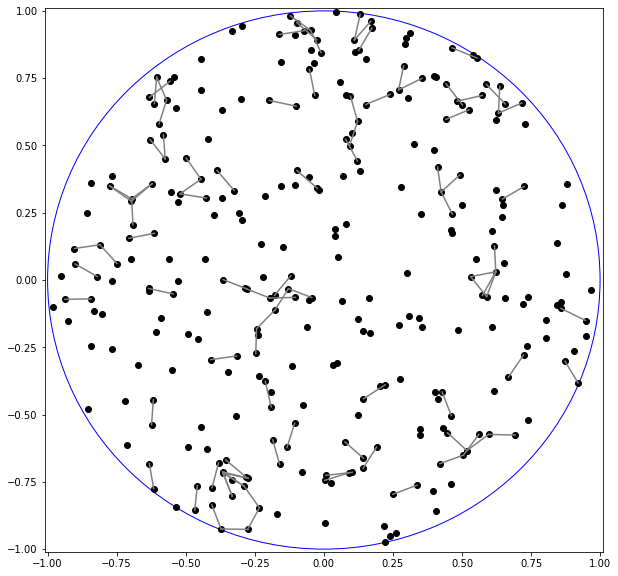

In [19]:
clu.show()

In [35]:
def create_subcluster_from_seed(connections, seed_index, ignore=[]):
    sub_cluster = subcluster([seed_index])
    for connection in connections[seed_index]:
        if connection not in ignore:
            sub_cluster.add_point(connection)
            sub_cluster.add_points(create_subcluster_from_seed(connections, connection, ignore=connections[seed_index]).points)

    return sub_cluster


In [24]:


#x, y = np.reshape(np.random.normal(0, radius_space, 2*N_points),(2, N_points))
#gaussian_cluster = np.array([[x[i]**2 + y[i]**2, np.arctan(y[i]/x[i])] for i in range(N_points)])

In [25]:
connections = all_connections(cluster_all, radius_shell, delta_shell)

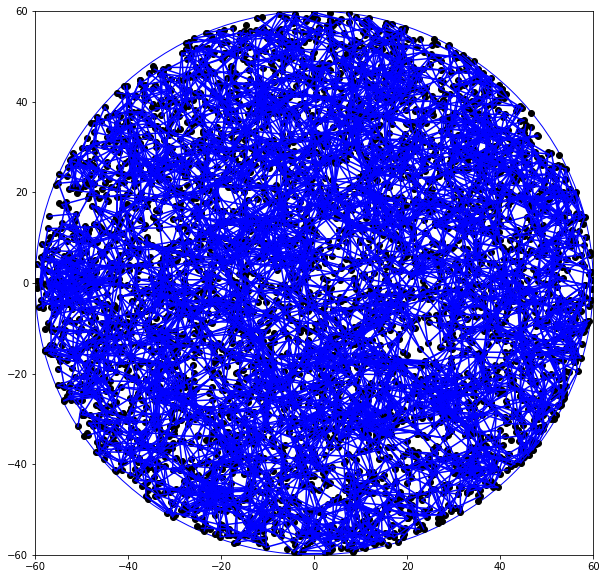

In [36]:
print_cluster(cluster_all, radius_space, connections)

In [55]:
sub_cluster_indeces = create_subcluster_from_seed(connections, 0, ignore=[]).points
sub_cluster_indeces

[0,
 15,
 48,
 59,
 156,
 96,
 97,
 145,
 359,
 707,
 983,
 368,
 373,
 114,
 294,
 390,
 429,
 738,
 880,
 523,
 797,
 1088,
 1314,
 1434,
 1596,
 1802,
 1994,
 2430,
 2961,
 3438,
 3483,
 4018,
 4123,
 4459,
 4886,
 4867,
 4965,
 4906,
 4133,
 4836,
 4891,
 4288,
 4621,
 4930,
 3660,
 3954,
 4404,
 4726,
 4744,
 4893,
 4934,
 4859,
 4387,
 4395,
 4794,
 4796,
 4945,
 3135,
 3545,
 4197,
 4374,
 4924,
 4427,
 4935,
 3957,
 1773,
 2273,
 2906,
 2427,
 3105,
 3271,
 3568,
 3611,
 3925,
 3697,
 4581,
 4987,
 3281,
 3301,
 3827,
 4599,
 4709,
 4701,
 4717,
 1856,
 2097,
 2369,
 3008,
 3803,
 4266,
 2754,
 3230,
 4023,
 4401,
 4493,
 4451,
 4876,
 3350,
 4195,
 4961,
 1417,
 1431,
 1215,
 1329,
 1533,
 1762,
 1806,
 2141,
 2473,
 2766,
 2776,
 3110,
 3708,
 3795,
 4208,
 4332,
 4437,
 4964,
 4996,
 4684,
 4948,
 4343,
 3874,
 3930,
 4488,
 4643,
 4957,
 3454,
 3778,
 4204,
 4177,
 4310,
 2831,
 3499,
 2406,
 2590,
 2720,
 2843,
 3194,
 4007,
 4904,
 4949,
 4022,
 4555,
 4878,
 3469,
 3364,

In [56]:
sub_cluster = np.array([cluster_all[:,i] for i in sub_cluster_indeces]).T
sub_cluster

array([[ 2.15591614,  3.74417265,  6.20951609, ..., 41.97544351,
        15.96869754, 16.07803433],
       [ 2.44244656,  5.68398176,  4.51025611, ...,  1.62282166,
         2.31774977,  2.46534632]])

In [57]:
connections

[[15, 27, 49, 56, 75],
 [24],
 [21],
 [],
 [24, 29, 33, 43, 67, 79],
 [69, 76],
 [9],
 [9, 23, 71],
 [41, 42, 87, 89],
 [35, 53],
 [58],
 [82],
 [],
 [16, 22, 26, 108],
 [83],
 [48, 59, 96, 97, 114],
 [21, 105],
 [27, 108, 119],
 [],
 [99, 109, 119],
 [37, 67, 121],
 [107, 124],
 [78],
 [36, 62],
 [26, 129],
 [54, 93],
 [38, 60, 79, 94, 136],
 [57, 73, 97, 142, 145],
 [],
 [44, 55, 58, 96, 129, 146],
 [119, 135, 144],
 [83],
 [69, 129],
 [150],
 [100, 131],
 [137],
 [37, 75],
 [59, 64, 82, 115],
 [85, 99, 104, 130, 131, 155],
 [61, 94, 110, 128],
 [46],
 [155, 161],
 [120],
 [70, 71, 143, 158],
 [69, 169, 170],
 [54, 70, 71, 81, 139, 143, 159],
 [],
 [109, 164, 173],
 [],
 [124],
 [118, 134, 164],
 [182],
 [140, 163, 186],
 [144],
 [60, 74, 91, 107, 184],
 [168],
 [160, 169],
 [],
 [84, 89, 152, 163],
 [156],
 [73, 190],
 [87, 102],
 [120, 203, 205],
 [193],
 [],
 [157, 209, 211],
 [157, 211],
 [68, 195],
 [142, 210],
 [129],
 [],
 [120, 209],
 [218],
 [156],
 [108, 185, 214],
 [78, 10

In [58]:
sub_cluster_connections = [connections[i] for i in sub_cluster_indeces]
sub_cluster_connections


[[15, 27, 49, 56, 75],
 [48, 59, 96, 97, 114],
 [],
 [156],
 [],
 [],
 [145],
 [359, 368, 373],
 [707],
 [983],
 [],
 [],
 [],
 [294],
 [390, 638],
 [429, 523],
 [738],
 [880],
 [],
 [797, 831],
 [1088, 1215],
 [1314, 1417, 1431],
 [1434, 1856],
 [1596, 1773],
 [1802, 1994],
 [],
 [2430],
 [2961, 3135],
 [3438, 3660],
 [3483, 4133, 4288],
 [4018],
 [4123, 4459, 4867, 4906],
 [],
 [4886],
 [],
 [4965],
 [],
 [],
 [4836, 4891],
 [],
 [],
 [4621],
 [4930],
 [],
 [3954, 4387],
 [4404, 4859],
 [4726, 4744],
 [],
 [4893, 4934],
 [],
 [],
 [],
 [4395, 4945],
 [4794],
 [4796],
 [],
 [],
 [3545, 3954, 3957],
 [4197],
 [4374, 4427, 4935],
 [4924],
 [],
 [4924, 4930],
 [],
 [4621],
 [2273, 2427],
 [2906],
 [],
 [3105],
 [3271, 3281, 3301, 3827],
 [3568, 3697],
 [3611],
 [3925],
 [4404],
 [4581],
 [4987],
 [],
 [3568, 3697],
 [3568, 3697, 3954],
 [4599, 4701, 4717],
 [4709],
 [],
 [],
 [],
 [2097],
 [2369, 2754],
 [3008],
 [3803],
 [4266, 4701],
 [],
 [3230, 3350],
 [4023],
 [4401, 4451, 4876],
 [

IndexError: list index out of range

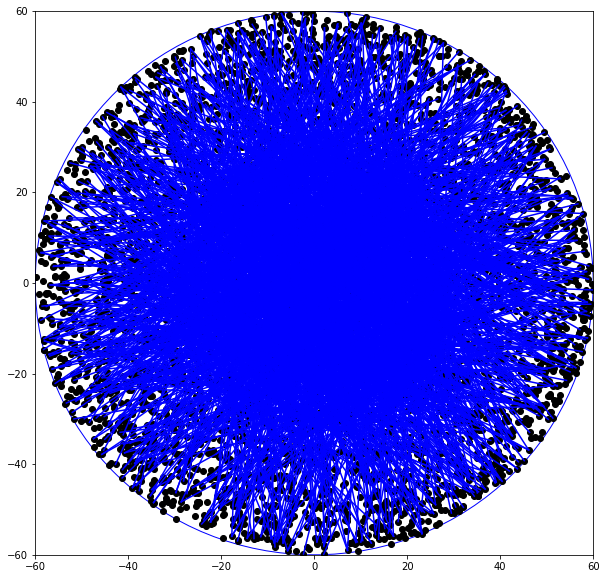

In [60]:
print_cluster(cluster, radius_space, sub_cluster_connections)

In [29]:
cluster_all

array([[ 2.15591614,  2.26813613,  2.28836095, ..., 59.97920315,
        59.98224637, 59.98356983],
       [ 2.44244656,  0.52976287,  4.18877325, ...,  3.8142192 ,
         5.01899423,  4.42120874]])

In [38]:
sub_cluster.T

array([[ 2.15591614,  3.74417265,  6.20951609, ..., 41.97544351,
        15.96869754, 16.07803433],
       [ 2.44244656,  5.68398176,  4.51025611, ...,  1.62282166,
         2.31774977,  2.46534632]])